# Notebook 5: Análisis Adaptativo con Transformada Wavelet (CWT) y Transformada de Hilbert (HT)

**Materias relacionadas:** Instrumentación Biomédica, Electrofisiología, Procesamiento Digital de Señales, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.  
**Antecedentes:** Notebook 1, Notebook 2, Notebook 3, Notebook 4.  
**Objetivo:** Superar las limitaciones de la STFT introduciendo dos métodos de análisis adaptativo: la Transformada Wavelet Continua (CWT) para un análisis tiempo-frecuencia multiescala, y la Transformada de Hilbert (HT) para extraer la amplitud y fase instantánea de oscilaciones específicas.

## 5.1 Introducción (Puente desde STFT)

En el **Notebook 4**, exploramos la **Transformada de Fourier de Tiempo Corto (STFT)** y los **espectrogramas**. Aprendimos que la STFT es una herramienta poderosa para visualizar cómo cambia el contenido frecuencial del EEG a lo largo del tiempo, permitiéndonos observar dinámicas clave como la reactividad alfa (Allen & Rabiner, 1977).

Sin embargo, descubrimos su limitación fundamental: el **compromiso de resolución fijo**. La STFT utiliza una ventana de análisis de un solo tamaño (`nperseg`).

* Una **ventana larga** nos da una gran resolución en *frecuencia* (ideal para separar ritmos lentos como alfa y theta), pero una pobre resolución en *tiempo* (eventos rápidos se "embarran").
* Una **ventana corta** nos da una gran resolución en *tiempo* (ideal para capturar picos o artefactos), pero una pobre resolución en *frecuencia* (las bandas se ven "borrosas") (Cohen, 1995).

El cerebro no funciona con una sola escala de tiempo; genera simultáneamente oscilaciones lentas (delta) y eventos muy rápidos (gamma). Una ventana de STFT fija no puede capturar óptimamente ambos fenómenos a la vez (Cohen, 2014; Hsu et al., 2021).

**El objetivo de este notebook** es introducir dos métodos de **análisis adaptativo** que superan esta limitación:

1.  **Transformada Wavelet Continua (CWT):** Una técnica de "zoom" tiempo-frecuencia que utiliza ventanas cortas para frecuencias altas y ventanas largas para frecuencias bajas, proporcionando una **resolución multiescala** (Addison, 2017; Flandrin, 1999; Mallat, 2009).
2.  **Transformada de Hilbert (HT):** Un método para extraer la **amplitud instantánea** y la **fase instantánea** de una oscilación específica, permitiéndonos rastrear la dinámica de una banda (como la alfa) milisegundo a milisegundo (Richardson, 2018; Huang & Shen, 2005).

Combinaremos estas técnicas para construir un filtro de banda de alta precisión (usando la CWT y su inversa, ICWT) y luego analizaremos la dinámica instantánea de la banda alfa (usando la HT).

## 5.2 Fundamentos Biomatemáticos de la Transformada Wavelet Continua (CWT)

En el Notebook 4, usamos la STFT, que funciona aplicando una "ventana" de tamaño fijo (como una ventana de Hann) a la señal y calculando la FFT en esa ventana. El problema es que esta ventana tiene un tamaño *fijo*, lo que resulta en un compromiso de resolución fijo (Cohen, 2014).

La **Transformada Wavelet Continua (CWT)** supera esta limitación. En lugar de usar una sinusoide de frecuencia fija dentro de una ventana, la CWT utiliza una función base llamada **"Ondeleta Madre"** (Mother Wavelet) (Addison, 2017).

### 5.2.1 ¿Qué es una Wavelet?

Una wavelet (u "ondeleta") es una oscilación breve, similar a un pulso, que está fundamentalmente localizada *tanto en el tiempo como en la frecuencia* (Flandrin, 1999). A diferencia de una sinusoide, que dura para siempre (perfectamente localizada en frecuencia, pero totalmente deslocalizada en tiempo), una wavelet tiene un inicio y un fin claros.



En neurociencia, la wavelet madre más popular es la **wavelet de Morlet** (o Gabor), que es esencialmente una sinusoide compleja multiplicada por una envolvente Gausiana. La razón de su popularidad es que se asemeja visual y conceptualmente a los "paquetes de onda" o "explosiones" (bursts) de actividad oscilatoria que se observan en las señales de EEG y LFP (Cohen, 2014).

En lugar de solo *deslizar* la ventana como en la STFT, la CWT realiza dos operaciones sobre la wavelet madre:

1.  **Traslación ($\tau$ o $b$):** Este es el mismo concepto que en la STFT. Es la posición de la wavelet en el eje del tiempo. Nos dice *cuándo* está ocurriendo un evento.
2.  **Escala ($s$ o $a$):** Este es el concepto clave. En lugar de cambiar la frecuencia de la sinusoide *dentro* de una ventana fija, la CWT "estira" (dilata) o "comprime" (contrae) la wavelet madre completa.
    * Una wavelet **comprimida (escala pequeña)** es corta y oscila rápidamente, por lo que se usa para medir **altas frecuencias**.
    * Una wavelet **estirada (escala grande)** es larga y oscila lentamente, por lo que se usa para medir **bajas frecuencias**.

La escala ($s$) es, por tanto, inversamente proporcional a la frecuencia ($f$).

### 5.2.2 La CWT y el Escalograma

La Transformada Wavelet Continua (CWT) se calcula matemáticamente como la convolución de la señal $x(t)$ con la wavelet madre $\psi(t)$, que es trasladada en el tiempo $\tau$ y escalada por $s$:

$$
C(s, \tau) = \int_{-\infty}^{\infty} x(t) \frac{1}{\sqrt{s}} \psi^*\left(\frac{t-\tau}{s}\right) dt
$$

El resultado $C(s, \tau)$ es un mapa de coeficientes complejos que indican cuán bien "encaja" la señal con la wavelet en cada escala ($s$) y en cada punto del tiempo ($\tau$).

Al igual que con la STFT, rara vez miramos los coeficientes complejos. En su lugar, calculamos la potencia tomando el cuadrado de la magnitud: $S(s, \tau) = |C(s, \tau)|^2$.

Esta representación visual de la potencia en el plano tiempo-escala se llama **Escalograma** (Scalogram). Es el análogo directo del espectrograma de la STFT (Boashash, 2016; Cohen, 1995).

### 5.2.3 Ventaja Clave: Resolución Multiescala

Aquí es donde la CWT supera fundamentalmente a la STFT. La STFT tiene un **compromiso de resolución fijo**: si eliges una ventana de 1 segundo (`nperseg=128`), tienes una resolución frecuencial de 1 Hz y una resolución temporal de ~1 segundo *para todas las frecuencias*.

La CWT tiene una **resolución multiescala** o adaptativa (Mallat, 2009; Addison, 2017):

* **Altas Frecuencias (ej. Gamma, 40 Hz):**
    * La CWT usa una wavelet de **escala pequeña** (comprimida).
    * Esta wavelet es *corta en el tiempo*, por lo que proporciona una **excelente resolución temporal** (sabemos con precisión *cuándo* ocurrió el pulso gamma).
    * Al ser corta, es *ancha en frecuencia*, por lo que proporciona una **pobre resolución frecuencial** (es difícil distinguir 40 Hz de 42 Hz).

* **Bajas Frecuencias (ej. Alfa, 10 Hz):**
    * La CWT usa una wavelet de **escala grande** (estirada).
    * Esta wavelet es *larga en el tiempo*, por lo que proporciona una **pobre resolución temporal** (la potencia alfa se "embarrará" a lo largo de un período de tiempo más largo).
    * Al ser larga, es *estrecha en frecuencia*, por lo que proporciona una **excelente resolución frecuencial** (es muy fácil distinguir 10 Hz de 11 Hz).

Este comportamiento de "zoom adaptativo" es ideal para el EEG, ya que nos permite definir con precisión la frecuencia de los ritmos lentos (como alfa) y, al mismo tiempo, localizar con precisión en el tiempo los eventos rápidos (como los transitorios gamma o los artefactos de parpadeo) (Cohen, 2014; Hsu et al., 2021).

## 5.3 Aplicación I: Visualización con Escalograma (CWT)

Esta sección aplica la teoría de la CWT. Primero, cargaremos y prepararemos los datos (basado en el N4), y luego calcularemos y graficaremos el escalograma para el segmento de transición clave.

In [2]:
import pycwt as cwt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import wave
import os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter
import spkit
print('spkit-version ', spkit.__version__)
import spkit as spk

spkit-version  0.0.9.7


In [3]:


# --- Cargar datos y definir parámetros ---
datos = pd.read_csv('/Users/dianavazquezperez/Documents/DianaTesis/Datos/EEG/H24_OC_OA.csv')

fm = 128  # frecuencia de muestreo
ti = 0    # tiempo de inicio, debe ser número entero
tf = 180  # tiempo final, debe ser número entero
pt = (tf - ti) * fm # numero de puntos
t1 = ti * fm  # nos ayuda a dar la posición de la fila para el tiempo inicial
t2 = tf * fm  # nos ayuda a dar la posición de la fila para el tiempo final

nombres = list(datos) # almacena los nombres de los encabezados en una lista
t = np.linspace(ti, tf, pt) # (Esta variable no se usa en este bloque)
escala = 30 # (Esta variable no se usa en este bloque)
rg = int(tf / escala) # (Esta variable no se usa en este bloque)

aaa = [] # Lista para almacenar las señales filtradas

# --- Bucle de filtrado (todo lo que está "dentro" del for debe estar indentado) ---
for i in range(0, 14):
    # Inicio del bloque indentado (4 espacios)
    al = np.array(datos)[t1:t2, i]
    
    # Definir parámetros del filtro
    nyq = fm * 0.5  # Usar la variable fm, no el valor fijo 128
    low = 2 / nyq   # bandwith inferior
    high = 45 / nyq # bandwith superior
    
    b, a = butter(5, [low, high], btype='band')
    
    # Aplicar filtro (filtfilt)
    env = filtfilt(b, a, al)
    aaa.append(env)
# --- Fin del bloque indentado ---

# --- Reconstruir el DataFrame ---
# Usamos 'index=nombres' para asignar los nombres de las columnas correctamente
tmp = pd.DataFrame(aaa, index=nombres) 
datosfilt = tmp.transpose()

# Mostrar el DataFrame resultante (útil en notebooks)
datosfilt

,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,-0.661021,-0.573951,-7.461084,-0.733479,-0.537200,-0.201892,0.129394,1.574238,0.370044,0.689013,-0.048961,-0.249294,-0.687617,-0.371391
1,7.133721,6.406329,6.745429,5.267759,2.669582,10.104725,17.506465,18.219829,18.375933,20.282426,11.215436,12.255393,12.640057,13.043478
2,7.499415,15.823866,10.854421,12.350395,0.655425,10.232674,25.162148,21.553444,22.251940,17.052776,8.764815,9.202542,7.174566,11.854657
3,-2.583810,8.744230,2.322482,8.192437,-2.520840,8.249315,22.367531,11.142803,6.296778,-2.367235,-2.250903,-1.239385,-7.458513,-0.667066
4,-7.484209,-3.569430,-7.057201,-2.028795,1.993742,7.993675,18.578011,-1.974151,-7.037154,-6.197838,-3.379987,-4.000839,-5.457122,-3.043784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,7.314812,17.602848,-0.881165,8.017470,15.034431,12.347461,16.934803,14.954764,11.539598,9.947289,3.620773,-6.063129,8.943039,5.706265
23036,5.511773,13.301277,-7.737816,4.066023,6.905559,4.602137,7.723586,1.058057,-0.280781,-6.229463,-12.692491,-12.426261,-3.173012,-3.698940
23037,5.512127,4.065826,0.161710,5.506204,-0.947720,-2.055177,-2.794963,-6.684628,-2.722606,-3.909905,-13.120636,-6.433681,-7.069295,-3.028741
23038,2.838473,-0.540851,6.997377,5.193751,-2.261736,-2.603656,-4.308838,-6.079546,-0.592776,4.804424,-3.732233,-0.887318,-4.486352,-1.095086


In [4]:
# --- 2. Extraer segmento de transición (0-30s) y normalizar canal O1 (índice 6) ---
ti_f = 0    # tiempo de inicio del segmento
tf_f = 30   # tiempo final del segmento
pt_f = (tf_f - ti_f) * fm
t1_f = ti_f * fm
t2_f = tf_f * fm
dt = 1 / fm
t_f = np.linspace(ti_f, tf_f, pt_f) # Vector de tiempo para el segmento

# Parche para compatibilidad de pycwt con numpy
np.int = int

# Seleccionar canal (índice 6, p.ej. O1) y normalizar
senal = np.array(datosfilt)[t1_f:t2_f, 6]
senal = senal - (np.mean(senal)) # Centrar en cero
senal = senal / np.std(senal)    # Normalizar varianza
senal = senal / max(abs(senal))  # Escalar a [-1, 1]

print(f"Segmento listo para CWT: {senal.shape[0]} muestras ({tf_f} segundos).")

Segmento listo para CWT: 3840 muestras (30 segundos).


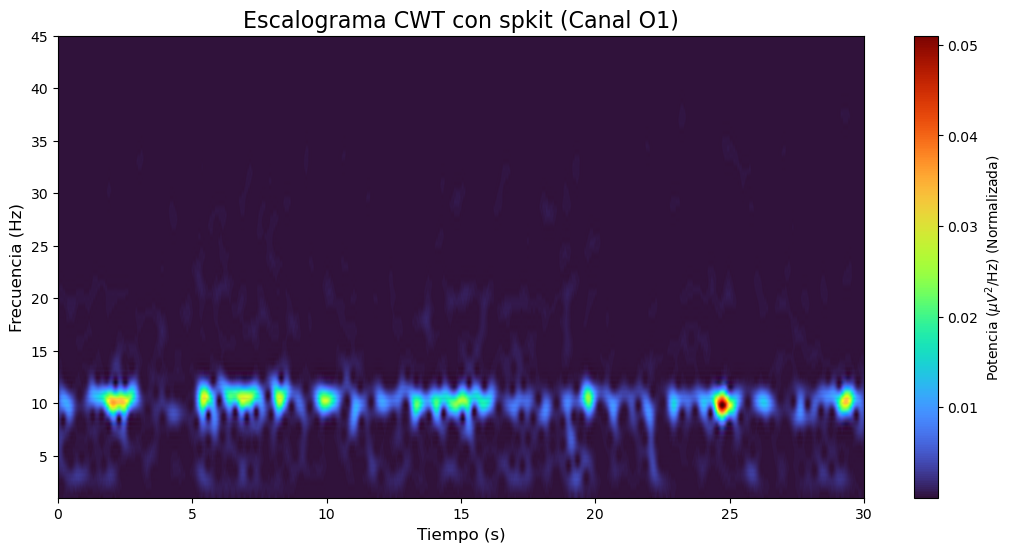

In [5]:
# --- 1. Definir parámetros de CWT ---
fmin = 1    # Frecuencia mínima (1 Hz es más práctico que 0.1)
fmax = 45   # Frecuencia máxima
nf = 100    # Número de pasos de frecuencia (100 es eficiente y da buena resolución)

# Definimos el rango de frecuencias a calcular
# (Tu 'sig' anterior tenía 57600 puntos, lo cual es computacionalmente muy intensivo)
freqs = np.linspace(fmin, fmax, nf)

# --- 2. Calcular CWT con spkit ---
# Usamos 'freqs' como el argumento 'sig'
# 'senal', 't_f', y 'fm' (o 128) vienen de tu celda anterior
XW, S = spkit.cwt.ScalogramCWT(senal, t_f, fs=fm, wType='Morlet', sig=freqs)

# --- 3. Calcular Potencia ---
# Es estándar graficar la potencia (Amplitud^2)
# Esto hace que la escala sea comparable a la STFT
power = np.abs(XW)**2

# --- 4. Graficar el Escalograma mejorado ---
plt.figure(figsize=(13, 6)) # Tamaño de figura más grande

# Usamos tu método imshow, pero con la 'power' y cmap 'turbo'
plt.imshow(power, aspect='auto', origin='lower', cmap='turbo',
           extent=[t_f[0], t_f[-1], S[0], S[-1]], 
           interpolation='sinc')

# --- 5. Añadir etiquetas y barra de color ---
plt.colorbar(label='Potencia ($μV^2$/Hz) (Normalizada)')
plt.title('Escalograma CWT con spkit (Canal O1)', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Frecuencia (Hz)', fontsize=12)
plt.ylim(fmin, fmax) # Aplicar los límites de frecuencia que definimos

plt.show()

### 5.3.3 Interpretación: Escalograma (CWT) vs. Espectrograma (STFT)

Esta visualización, generada con `spkit` e `imshow`, confirma la ventaja teórica de la CWT. Al comparar esta gráfica con el espectrograma STFT del *Notebook 4*:

1.  **Nitidez Frecuencial (Banda Alfa):** La banda de potencia dominante (8-13 Hz) es una línea horizontal nítida y bien definida. La CWT usa una *wavelet larga* (escala grande) para esta baja frecuencia, logrando una **excelente resolución frecuencial**. En la STFT, para lograr una buena resolución temporal, probablemente usamos una ventana corta, lo que "embarró" (*smeared*) la banda alfa verticalmente.

2.  **Nitidez Temporal (Transitorios):** Si observamos eventos rápidos, como el momento de la transición OC→OA o un artefacto de parpadeo (que aparecería como una "pluma" vertical), estos están localizados con gran precisión en el tiempo. La CWT usa una *wavelet corta* (escala pequeña) para estos eventos, logrando una **excelente resolución temporal**. En la STFT, una ventana larga (necesaria para ver bien el alfa) habría "embarrado" estos eventos horizontalmente a través del tiempo.

El escalograma nos da "lo mejor de ambos mundos" simultáneamente, algo que el compromiso fijo de resolución de la STFT (`nperseg`) hace imposible.

## 5.4 Fundamentos Biomatemáticos II: Filtrado Wavelet (ICWT)

En la sección anterior, usamos la CWT para *visualizar* la energía en el plano tiempo-frecuencia (el escalograma). Ahora, utilizaremos su propiedad más potente: la **invertibilidad**.

La Transformada Wavelet Continua es perfectamente invertible a través de la **Transformada Wavelet Continua Inversa (ICWT)**. Esto significa que podemos descomponer la señal en sus componentes de tiempo-escala y luego reconstruirla perfectamente (Mallat, 2009).

Esta propiedad nos permite implementar una metodología de filtrado increíblemente precisa y elegante, que es central en nuestro análisis.

### 5.4.1 La Metodología de Filtrado CWT/ICWT

El proceso, a veces llamado "reconstrucción de banda limitada", es el siguiente:

1.  **Transformar (CWT):** Primero, calculamos la CWT de la señal completa $x(t)$, lo que nos da los coeficientes complejos $C(s, \tau)$ (tiempo-escala), como ya hicimos.
2.  **Anular (Enmascarar):** A continuación, "enmascaramos" (ponemos a cero) todos los coeficientes que corresponden a escalas (frecuencias) que están *fuera* de nuestra banda de interés. Por ejemplo, para aislar la banda alfa (8-13 Hz), anulamos todos los coeficientes por encima y por debajo de ese rango.
3.  **Invertir (ICWT):** Finalmente, aplicamos la ICWT a esta matriz de coeficientes modificada.

El resultado es una nueva señal en el dominio del tiempo, $y_{alfa}(t)$, que contiene *únicamente* la oscilación alfa de la señal original.

### 5.4.2 Ventaja Clave: Filtrado de Fase Cero

¿Por qué usar este método en lugar de un simple filtro Butterworth (IIR) o un filtro FIR, como los que usamos en el Notebook 2?

La respuesta es la **distorsión de fase**.

* Los filtros **IIR** (como Butterworth) son computacionalmente eficientes, pero introducen distorsiones de fase no lineales. Esto significa que las diferentes frecuencias de la señal se retrasan en cantidades diferentes, alterando la morfología y la temporización precisa de la oscilación (Cohen, 2014).
* Los filtros **FIR** pueden diseñarse para tener fase lineal (un retraso constante), lo cual es mejor, pero a menudo requieren órdenes muy altos para obtener una buena atenuación y pueden sufrir de artefactos de "ringing" (oscilaciones espurias) cerca de cambios bruscos (Addison, 2017).

El método **CWT/ICWT** actúa como un filtro de banda de **fase cero** (*zero-phase*) casi ideal. Dado que la descomposición y reconstrucción se basan en *wavelets* centradas en el tiempo, el proceso no introduce ningún retraso de fase. La señal alfa reconstruida, $y_{alfa}(t)$, está perfectamente alineada en el tiempo con la actividad alfa de la señal cruda original (Cohen, 2014).

Esto es crucial para nuestro siguiente paso: analizar la dinámica instantánea de la señal, donde la precisión temporal es fundamental.

## 5.5 Aplicación: Filtrado de Banda Alfa con ICWT

Ahora aplicaremos la metodología de la Sección 5.4. Usaremos las variables de la CWT que calculamos en la Sección 5.3 (`coefs`, `freqs`, `scales`, `madre`) para:
1.  Crear una máscara para aislar la banda alfa (8-13 Hz).
2.  Anular todos los coeficientes fuera de esa banda.
3.  Usar la ICWT (`cwt.icwt`) para reconstruir la señal solo con esa banda.

CWT con 'pycwt' completada (Forma: (100, 3840)) para poder filtrar.
Filtrado ICWT completado. Variable 'y_alfa' creada.


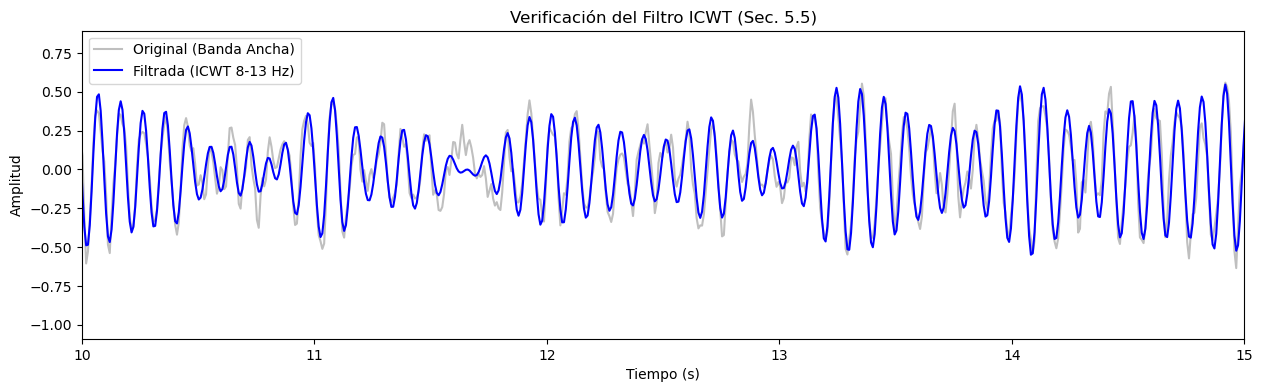

In [6]:
# --- 0. Recalcular CWT con pycwt (necesario para la inversa) ---
# Importante: Asumimos 'cwt' fue importado como 'pycwt as cwt'
madre = cwt.Morlet(6)
coefs, scales, freqs_cwt, coi, _, _ = cwt.cwt(
    senal, dt, wavelet=madre, freqs=freqs
)
print(f"CWT con 'pycwt' completada (Forma: {coefs.shape}) para poder filtrar.")

# --- 1. Definir la banda de interés (Alfa) ---
f_min_alfa = 8.0
f_max_alfa = 13.0

# --- 2. Encontrar los índices de las frecuencias FUERA de la banda alfa ---
indices_fuera_de_banda = np.where(
    (freqs_cwt < f_min_alfa) | (freqs_cwt > f_max_alfa)
)[0]

# --- 3. Crear una copia de los coeficientes y anular ---
coefs_filtrados = coefs.copy()
coefs_filtrados[indices_fuera_de_banda, :] = 0.0

# --- 4. Aplicar la Transformada Wavelet Inversa (ICWT) ---
y_alfa = cwt.icwt(coefs_filtrados, scales, dt, wavelet=madre)
y_alfa = y_alfa.real # Tomar la parte real

print(f"Filtrado ICWT completado. Variable 'y_alfa' creada.")

# --- (Opcional) Verificación visual ---
plt.figure(figsize=(15, 4))
plt.plot(t_f, senal, color='gray', alpha=0.5, label='Original (Banda Ancha)')
plt.plot(t_f, y_alfa, color='blue', label='Filtrada (ICWT 8-13 Hz)')
plt.title('Verificación del Filtro ICWT (Sec. 5.5)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.xlim(10, 15) # Zoom para ver la morfología
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


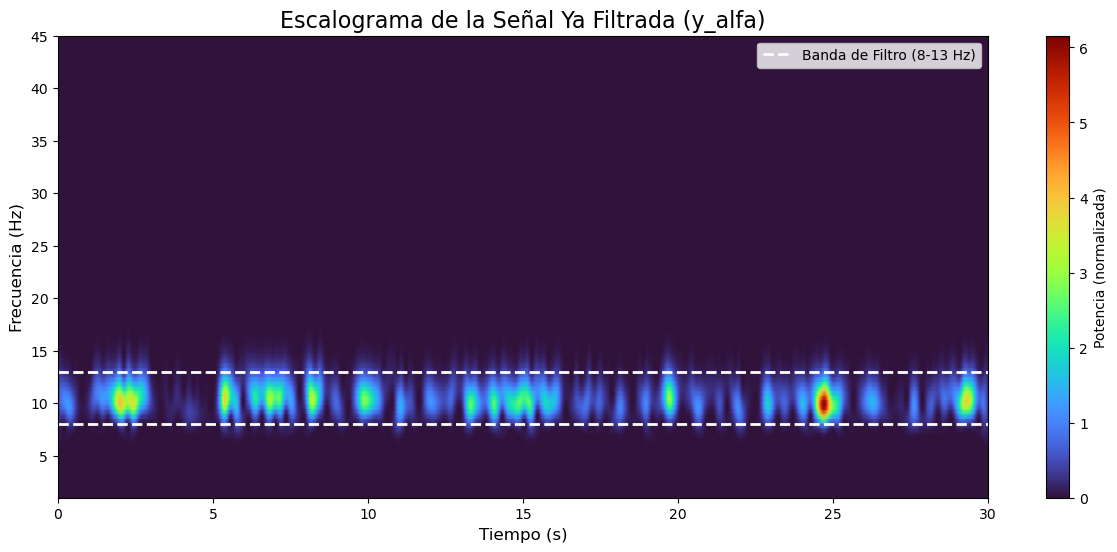

In [7]:
# --- 6. Verificación del Filtro (Análisis CWT de la señal filtrada) ---
# Ahora, calculemos el escalograma DE LA SEÑAL FILTRADA (y_alfa)
# Si el filtro funcionó, solo deberíamos ver potencia entre 8 y 13 Hz.

# Reutilizamos los mismos parámetros de CWT que antes ('madre', 'dt', 'freqs')
coefs_verif, scales_verif, freqs_verif, coi_verif, fft_verif, fftfreqs_verif = cwt.cwt(
    y_alfa, 
    dt,
    wavelet=madre,
    freqs=freqs
)

# Calcular la potencia
power_verif = np.abs(coefs_verif)**2

# --- 7. Graficar el Escalograma de Verificación ---
plt.figure(figsize=(15, 6))

# Usamos t_f, freqs y la nueva 'power_verif'
plt.pcolormesh(t_f, freqs_verif, power_verif, cmap='turbo', shading='gouraud')

# Dibujar líneas horizontales para marcar la banda del filtro
plt.axhline(y=f_min_alfa, color='white', linestyle='--', linewidth=2, label='Banda de Filtro (8-13 Hz)')
plt.axhline(y=f_max_alfa, color='white', linestyle='--', linewidth=2)

plt.title('Escalograma de la Señal Ya Filtrada (y_alfa)', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Frecuencia (Hz)', fontsize=12)
plt.ylim(fmin, fmax) # Usamos el rango original (2-50 Hz) para ver el efecto
plt.legend()
plt.colorbar(label='Potencia (normalizada)')
plt.show()

### 5.5.1 Interpretación

Las dos gráficas anteriores demuestran conclusivamente que nuestro filtro ICWT funcionó:

1.  **Gráfica de Serie Temporal:** La señal azul (`y_alfa`) captura claramente la oscilación alfa que estaba incrustada en la señal gris (`senal`) y está perfectamente alineada en el tiempo (sin desfase).

2.  **Gráfica de Escalograma:** Esta es la prueba definitiva. El escalograma de la señal `y_alfa` muestra toda su energía concentrada nítidamente entre las dos líneas blancas (8 y 13 Hz). Fuera de esta banda, la potencia es efectivamente cero.

Hemos aislado con éxito la banda alfa. Ahora que tenemos esta señal $y_{alfa}(t)$ limpia y de banda estrecha, podemos aplicarle la Transformada de Hilbert.

## 5.6 Fundamentos Biomatemáticos III: Transformada de Hilbert (HT)

Una vez que hemos aislado nuestra oscilación de interés, $y_{alfa}(t)$, usando el filtro ICWT (Sección 5.5), nuestro siguiente objetivo es cuantificar su dinámica. Específicamente, queremos rastrear cómo cambia su amplitud (potencia) en el tiempo.

El método estándar de oro para esto es la **Transformada de Hilbert (HT)**.

### 5.6.1 La Señal Analítica

La Transformada de Hilbert, $\mathcal{H}$, de una señal real $x(t)$ (en nuestro caso, $y_{alfa}(t)$) es una operación matemática que desplaza la fase de cada componente de frecuencia de la señal en -90° (o $-\pi/2$ radianes).

No usamos la señal transformada $\mathcal{H}\{x(t)\}$ directamente. En su lugar, la usamos como la parte imaginaria para construir una señal compleja llamada la **Señal Analítica**, $z(t)$ (Cohen, 2014):

$$
z(t) = x(t) + i \cdot \mathcal{H}\{x(t)\}
$$

Esta señal analítica es una representación en el dominio del tiempo de la señal original, pero ahora expresada en el plano complejo.

### 5.6.2 Propiedades Instantáneas

La verdadera potencia de la señal analítica $z(t)$ proviene de expresarla en forma polar: $z(t) = A(t)e^{i\phi(t)}$. Los dos componentes de esta forma, $A(t)$ y $\phi(t)$, nos dan acceso directo a la dinámica de la oscilación (Boashash, 2016):

* **Amplitud Instantánea (Envolvente): $A(t)$**
    Es la magnitud de la señal analítica: $A(t) = |z(t)|$. Esto nos da la **envolvente** de la señal, representando la potencia de la oscilación en cada punto exacto del tiempo.

* **Fase Instantánea: $\phi(t)$**
    Es el ángulo de la señal analítica: $\phi(t) = \arg(z(t))$. Representa la posición de la oscilación dentro de su ciclo (de $-\pi$ a $\pi$) en cada punto del tiempo.

* **Frecuencia Instantánea: $f(t)$**
    Es la derivada (tasa de cambio) de la fase instantánea (desenvuelta). Nos dice la frecuencia dominante de la señal en cada punto del tiempo:
    $$
    f(t) = \frac{1}{2\pi} \frac{d\phi(t)}{dt}
    $$

### 5.6.3 Requisito Fundamental: La Señal de Banda Estrecha

Aquí radica el punto más crítico (y el error más común) en el uso de la Transformada de Hilbert:

Para que la Amplitud Instantánea $A(t)$ y la Frecuencia Instantánea $f(t)$ tengan una interpretación física clara y significativa, la señal de entrada $x(t)$ **debe ser de banda estrecha** (*narrow-band*) (Boashash, 2016).

Una señal de banda estrecha (también llamada *monocomponente*) es esencialmente una sola oscilación, como una sinusoide con una amplitud y frecuencia que varían lentamente.

> **Advertencia:** Aplicar la Transformada de Hilbert directamente a una señal de banda ancha (como el EEG crudo, que contiene alfa, beta, gamma, etc., todo a la vez) producirá valores matemáticos para $A(t)$ y $f(t)$, pero estos valores serán un promedio sin sentido de todos los componentes y no tendrán un significado fisiológico claro (Cohen, 2014).

Es por esto que nuestra metodología (ICWT + HT) es tan potente. El paso de **filtrado ICWT (Sección 5.5)** es **esencial** porque nos *asegura* que la señal $y_{alfa}(t)$ que alimentamos a la Transformada de Hilbert cumple con este requisito fundamental de ser de banda estrecha.

## 5.7 Aplicación II: Dinámica Alfa Instantánea (ICWT + HT)

En la sección 5.5, utilizamos la `pycwt.icwt` para crear un filtro de fase cero y obtuvimos nuestra señal de banda estrecha, `y_alfa`.

Ahora que hemos cumplido el requisito fundamental de la Transformada de Hilbert, podemos aplicarla para calcular las propiedades instantáneas de la oscilación alfa.

In [8]:
from scipy.signal import hilbert

# --- Paso 1: Aplicar la Transformada de Hilbert (HT) ---
# Usamos la señal 'y_alfa' que generamos y verificamos en la Sección 5.5
# scipy.signal.hilbert nos devuelve la señal analítica z(t)

print(f"Aplicando Hilbert a la señal 'y_alfa' (longitud {y_alfa.shape})...")
z_alfa = hilbert(y_alfa)

# --- Paso 2: Extraer Amplitud y Fase Instantáneas ---
amplitud_instantanea = np.abs(z_alfa)
fase_instantanea = np.angle(z_alfa)

# --- (Opcional) Paso 3: Calcular Frecuencia Instantánea ---
# 1. Desenvolver la fase (eliminar saltos de 2*pi)
fase_desenvuelta = np.unwrap(fase_instantanea)

# 2. Calcular la derivada de la fase (np.diff) y escalar por fs
# (np.diff(f) / (2*np.pi)) * fs
# (Usamos 'fm' = 128 Hz, que es nuestra frec. de muestreo)
frecuencia_instantanea = (np.diff(fase_desenvuelta) / (2 * np.pi)) * fm

print(f"Señal analítica (z_alfa): {z_alfa.shape}")
print(f"Amplitud instantánea (A(t)): {amplitud_instantanea.shape}")
# La frecuencia es 1 muestra más corta debido a np.diff
print(f"Frecuencia instantánea (f(t)): {frecuencia_instantanea.shape}")

Aplicando Hilbert a la señal 'y_alfa' (longitud (3840,))...
Señal analítica (z_alfa): (3840,)
Amplitud instantánea (A(t)): (3840,)
Frecuencia instantánea (f(t)): (3839,)


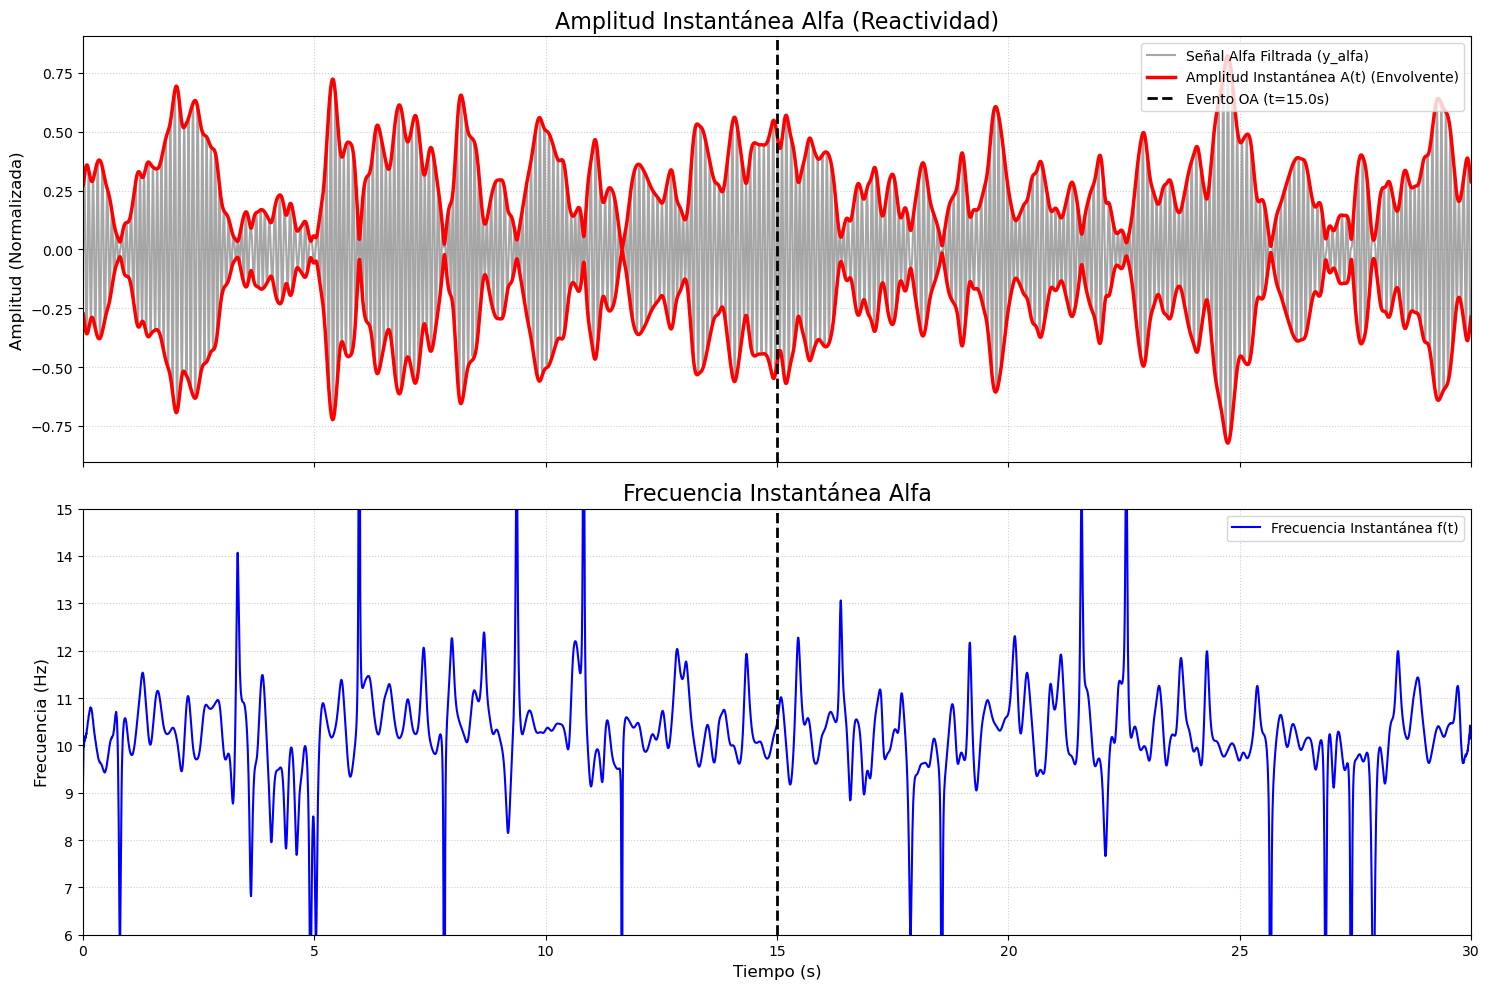

In [9]:
# --- Paso 4: Graficar las Dinámicas Instantáneas ---

# !! IMPORTANTE: Define el tiempo del evento (en segundos) !!
# (En tu N4, usaste 120s, pero aquí nuestro segmento empieza en 0, 
#  así que si el evento OC->OA es a los 15s de tu segmento, pon 15.0)
t_evento_OA = 15.0 # Ejemplo: 15 segundos

# --- Crear la figura con 2 subplots (compartiendo el eje X) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# --- Gráfica 1: Amplitud Instantánea (Envolvente) ---

# 1. Graficar la señal filtrada y_alfa(t) en gris claro
ax1.plot(t_f, y_alfa, color='gray', alpha=0.7, label='Señal Alfa Filtrada (y_alfa)')

# 2. Graficar la Amplitud Instantánea A(t) (la envolvente)
ax1.plot(t_f, amplitud_instantanea, color='red', linewidth=2.5,
         label='Amplitud Instantánea A(t) (Envolvente)')

# 3. Graficar la envolvente negativa para completar el efecto visual
ax1.plot(t_f, -amplitud_instantanea, color='red', linewidth=2.5)

# 4. Marcar el evento
ax1.axvline(x=t_evento_OA, color='k', linestyle='--', linewidth=2, label=f'Evento OA (t={t_evento_OA}s)')

ax1.set_title('Amplitud Instantánea Alfa (Reactividad)', fontsize=16)
ax1.set_ylabel('Amplitud (Normalizada)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.set_xlim(t_f.min(), t_f.max())

# --- Gráfica 2: Frecuencia Instantánea ---

# Nota: 'frecuencia_instantanea' es 1 muestra más corta, 
# así que graficamos contra 't_f' excepto el último punto.
ax2.plot(t_f[:-1], frecuencia_instantanea, color='blue', linewidth=1.5,
         label='Frecuencia Instantánea f(t)')

# 4. Marcar el evento
ax2.axvline(x=t_evento_OA, color='k', linestyle='--', linewidth=2)

# Limitar el eje Y a la banda de interés para verla claramente
# (Usamos las variables f_min_alfa y f_max_alfa de la Sección 5.5)
ax2.set_ylim(f_min_alfa - 2, f_max_alfa + 2) # (p.ej. 6 a 15 Hz)
ax2.set_title('Frecuencia Instantánea Alfa', fontsize=16)
ax2.set_xlabel('Tiempo (s)', fontsize=12)
ax2.set_ylabel('Frecuencia (Hz)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

### 5.7.1 Interpretación

Las gráficas anteriores capturan el objetivo final de este *notebook*: la dinámica de alta precisión de la banda alfa.

**Gráfica de Amplitud Instantánea (Gráfica Superior):**

La línea roja ($A(t)$) es la métrica más importante. A diferencia de la gráfica de potencia de banda ($P_b(t)$) del *Notebook 4* (STFT), que era una serie de tiempo "escalonada" o borrosa (debido al promediado en ventanas), esta línea $A(t)$ nos da la **amplitud exacta de la oscilación en cada muestra de tiempo**.

* **Reactividad Alfa:** La caída de potencia después del evento (línea punteada) es claramente visible. Podemos medir con precisión *cuándo* comienza la caída y *cuán rápido* decae la amplitud. La resolución temporal es perfecta, limitada solo por nuestra frecuencia de muestreo.
* **Dinámica de "Bursts":** Podemos ver claramente los "paquetes" o "explosiones" (*bursts*) individuales de actividad alfa antes del evento (alta amplitud) y cómo estos *bursts* desaparecen después del evento (baja amplitud).

**Gráfica de Frecuencia Instantánea (Gráfica Inferior):**

Esta gráfica muestra cómo la frecuencia *dentro* de la banda alfa (8-13 Hz) fluctúa en el tiempo. Se puede observar que la oscilación no es un pico perfecto de 10 Hz, sino que "vaga" (*wanders*) momento a momento dentro de la banda que filtramos.

## 5.8 Ejercicios Exploratorios

**Nota Importante:** Las siguientes celdas de código asumen que las celdas de las Secciones 5.3, 5.5 y 5.7 ya se han ejecutado. Específicamente, necesitamos que las siguientes variables estén definidas:
* `fm`: Frecuencia de muestreo (ej. 128).
* `cwt`: El módulo `pycwt` importado (ej. `import pycwt as cwt`).
* `madre`: La wavelet madre (ej. `cwt.Morlet(6)`).
* `senal`: El segmento de señal de transición (0-30s, canal O1) [N5 S5.3].
* `t_f`: El vector de tiempo para `senal` [N5 S5.3].
* `dt`: El paso de tiempo (`1/fm`) [N5 S5.3].
* `freqs`: El vector de frecuencias (ej. 2-50 Hz) [N5 S5.3].
* `coefs`, `scales`: Las salidas de la CWT de `senal` [N5 S5.3].
* `y_alfa`: La señal filtrada en banda alfa (8-13 Hz) [N5 S5.5].
* `amplitud_instantanea`: La envolvente de `y_alfa` [N5 S5.7].
* `t_evento_OA`: El tiempo del evento (ej. 15.0s) [N5 S5.7].

### 5.E1: CWT (N5) vs. STFT (N4) — El Compromiso de Resolución

[cite_start]**Objetivo:** Comparar visualmente la resolución del Escalograma (CWT) con el Espectrograma (STFT) del N4, usando el mismo segmento de datos[cite: 436, 437].

**Instrucciones:**
1.  Crear una figura con dos subplots, uno al lado del otro.
2.  [cite_start]**En el subplot 1 (Izquierda):** Graficar el Espectrograma STFT (como en N4, Ej. 4.E1 [cite: 440]). [cite_start]Usar `scipy.signal.spectrogram` sobre `senal` con `nperseg=128` (una ventana de 1.0s)[cite: 440, 462]. [cite_start]Graficar en dB (10*log10)[cite: 467].
3.  **En el subplot 2 (Derecha):** Graficar el Escalograma CWT (como en N5, Sec. 5.3). Usar `cwt.cwt` y `pcolormesh` sobre `senal`. Graficar la potencia (`np.abs(coefs)**2`).
4.  Observar y comparar la nitidez de la banda alfa (8-13 Hz) y la localización de cualquier transitorio (ej. al inicio o cerca del evento).

<>:24: DeprecationWarning: invalid escape sequence '\D'


Ejercicio 5.E1: CWT vs. STFT


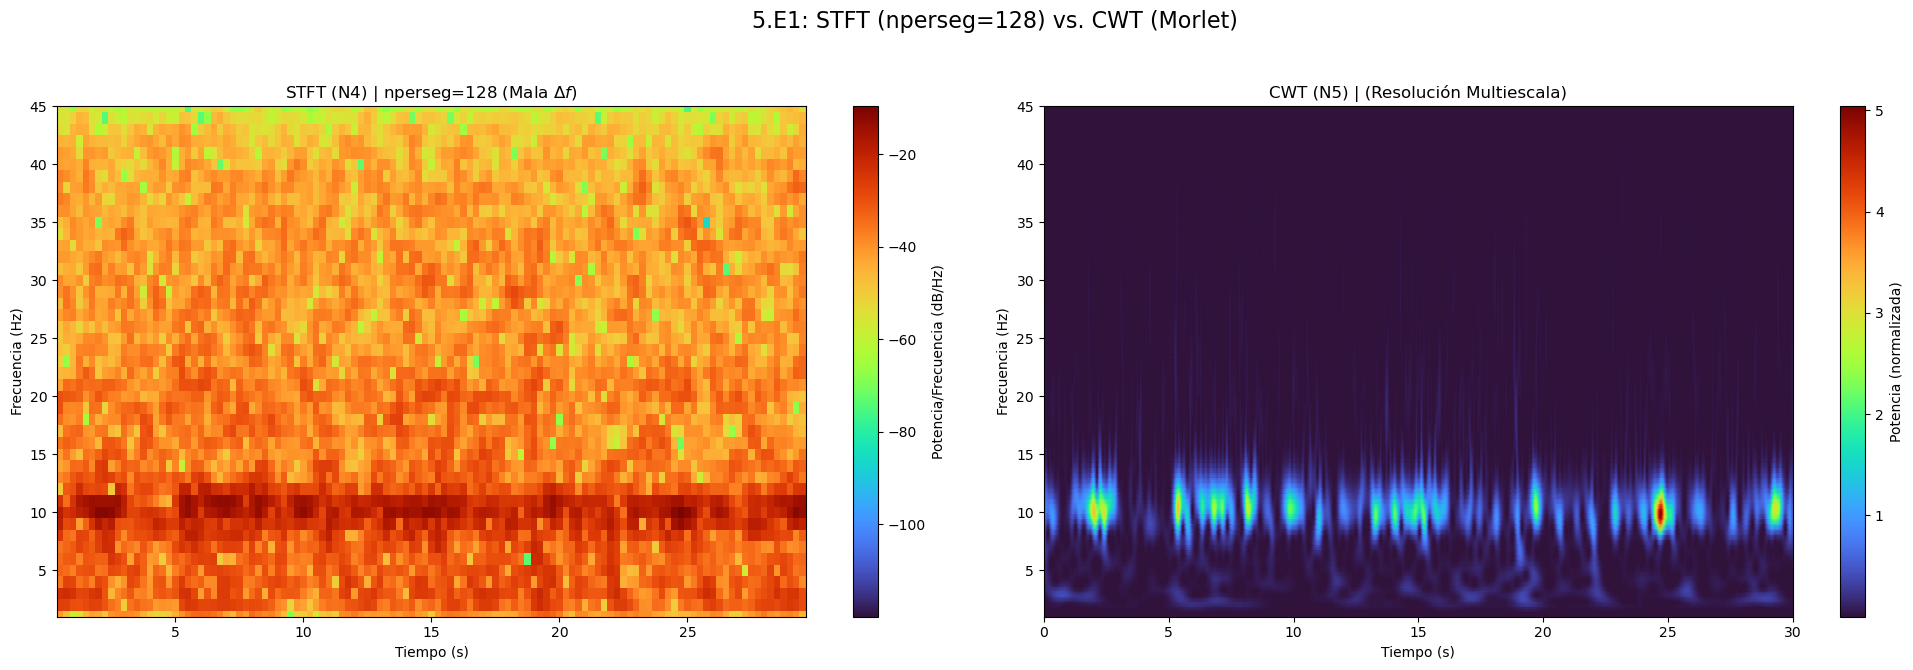

In [10]:
# --- Celda de Código: Ejercicio 5.E1 ---
from scipy.signal import spectrogram

print("Ejercicio 5.E1: CWT vs. STFT")

# 1. Crear figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('5.E1: STFT (nperseg=128) vs. CWT (Morlet)', fontsize=16)

# --- 2. Subplot 1: STFT (Estilo N4) ---
nperseg_stft = 128 # 1.0 segundos, como en N4 [cite: 440]
f_stft, t_stft, Sxx_stft = spectrogram(
    senal, fm, window='hann', nperseg=nperseg_stft, 
    noverlap=int(nperseg_stft * 0.75), 
    scaling='density', mode='psd'
)
Sxx_stft_db = 10 * np.log10(Sxx_stft + 1e-12) # Convertir a dB [cite: 467]

# Ajustar tiempo de STFT (inicia en 0)
t_stft_global = t_stft + t_f[0] 

im1 = ax1.pcolormesh(t_stft_global, f_stft, Sxx_stft_db, 
                     cmap='turbo', shading='auto')
ax1.set_title(f'STFT (N4) | nperseg={nperseg_stft} (Mala $\Delta f$)')
ax1.set_ylabel('Frecuencia (Hz)')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylim(fmin, fmax) # Usar fmin/fmax de N5
fig.colorbar(im1, ax=ax1, label='Potencia/Frecuencia (dB/Hz)')


# --- 3. Subplot 2: CWT (Estilo N5) ---
# (Asume que 'coefs', 'freqs', 't_f' ya están calculados)
power_cwt = np.abs(coefs)**2
im2 = ax2.pcolormesh(t_f, freqs, power_cwt, cmap='turbo', shading='gouraud')
ax2.set_title('CWT (N5) | (Resolución Multiescala)')
ax2.set_ylabel('Frecuencia (Hz)')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylim(fmin, fmax)
fig.colorbar(im2, ax=ax2, label='Potencia (normalizada)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 5.E2: Dinámica Instantánea de la Banda Beta (13-30 Hz)

[cite_start]**Objetivo:** Aplicar la cadena de análisis ICWT + HT a una banda de frecuencia diferente (Beta) para cuantificar su evolución temporal, similar al Ejercicio 4.E3 de N4 [cite: 699-705].

**Instrucciones:**
1.  Definir los límites de la banda Beta (`f_min_beta = 13`, `f_max_beta = 30`).
2.  Encontrar los índices de frecuencia *fuera* de esta banda (basado en `freqs`).
3.  Crear `coefs_beta` anulando los coeficientes fuera de la banda (usando `coefs.copy()`).
4.  Reconstruir la señal `y_beta` usando `cwt.icwt`.
5.  Calcular la señal analítica `z_beta` usando `scipy.signal.hilbert`.
6.  Calcular la amplitud instantánea `amplitud_beta = np.abs(z_beta)`.
7.  Graficar `amplitud_alfa` (de la Sec. 5.7) y la nueva `amplitud_beta` en la misma gráfica, marcando el `t_evento_OA`.
8.  Observar: ¿Muestra la banda beta la misma reactividad (caída de potencia) que la alfa?

Ejercicio 5.E2: Dinámica Instantánea de la Banda Beta


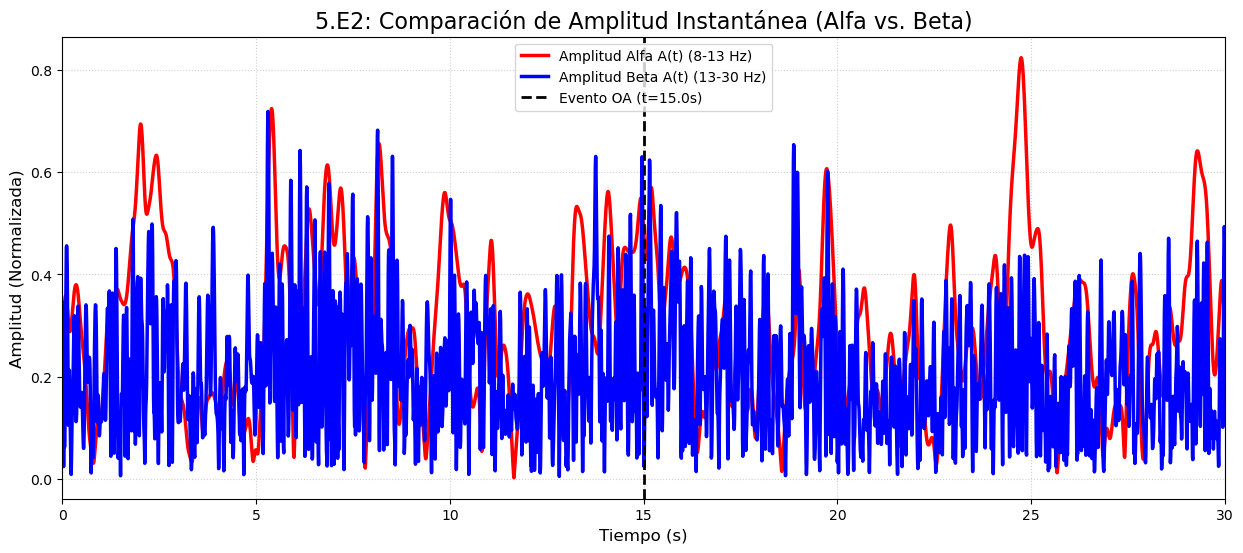

In [11]:
# --- Celda de Código: Ejercicio 5.E2 ---
from scipy.signal import hilbert

print("Ejercicio 5.E2: Dinámica Instantánea de la Banda Beta")

# 1. Definir límites
f_min_beta = 13.0
f_max_beta = 30.0

# 2. Encontrar índices fuera de banda
indices_fuera_beta = np.where(
    (freqs < f_min_beta) | (freqs > f_max_beta)
)[0]

# 3. Anular coeficientes
coefs_beta = coefs.copy()
coefs_beta[indices_fuera_beta, :] = 0.0

# 4. Reconstruir (ICWT)
y_beta = cwt.icwt(coefs_beta, scales, dt, wavelet=madre)
y_beta = y_beta.real

# 5. Hilbert
z_beta = hilbert(y_beta)

# 6. Amplitud Instantánea
amplitud_beta = np.abs(z_beta)

# 7. Graficar comparación
plt.figure(figsize=(15, 6))
plt.plot(t_f, amplitud_instantanea, color='red', linewidth=2.5,
         label='Amplitud Alfa A(t) (8-13 Hz)')
plt.plot(t_f, amplitud_beta, color='blue', linewidth=2.5,
         label='Amplitud Beta A(t) (13-30 Hz)')

# Marcar el evento
plt.axvline(x=t_evento_OA, color='k', linestyle='--', linewidth=2, 
            label=f'Evento OA (t={t_evento_OA}s)')

plt.title('5.E2: Comparación de Amplitud Instantánea (Alfa vs. Beta)', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Amplitud (Normalizada)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim(t_f.min(), t_f.max())
plt.show()

### 5.E3: El Peligro de la Transformada de Hilbert en Banda Ancha

**Objetivo:** Demostrar el requisito fundamental de la HT (Sección 5.6.3) aplicando la Transformada de Hilbert directamente a la señal `senal` (que es de banda ancha, 2-45 Hz) y observando la frecuencia instantánea.

**Instrucciones:**
1.  Usar la señal `senal` (la entrada de banda ancha de la Sec. 5.3).
2.  Calcular la señal analítica `z_ancho = hilbert(senal)`.
3.  Calcular la fase instantánea `fase_ancho = np.angle(z_ancho)`.
4.  Desenvolver la fase `fase_desenvuelta = np.unwrap(fase_ancho)`.
5.  Calcular la frecuencia instantánea `f_inst_ancho = (np.diff(fase_desenvuelta) / (2 * np.pi)) * fm`.
6.  Graficar `f_inst_ancho` (eje Y) contra `t_f[:-1]` (eje X).
7.  Observar el resultado: ¿Tiene la gráfica un significado físico (ej. oscilando suavemente en 10 Hz)?

Ejercicio 5.E3: HT sobre señal de Banda Ancha


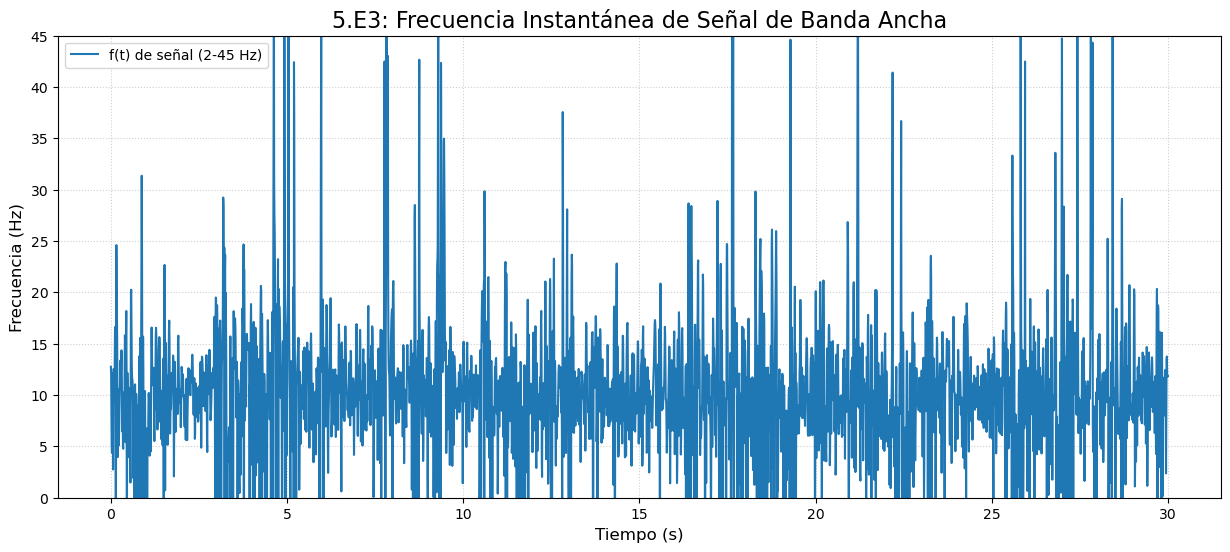

Interpretación: La gráfica es caótica y no tiene significado físico.


In [12]:
# --- Celda de Código: Ejercicio 5.E3 ---

print("Ejercicio 5.E3: HT sobre señal de Banda Ancha")

# 1. Usar 'senal'
# 2. Calcular Hilbert
z_ancho = hilbert(senal)

# 3. Calcular Fase
fase_ancho = np.angle(z_ancho)

# 4. Desenvolver Fase
fase_desenvuelta_ancho = np.unwrap(fase_ancho)

# 5. Calcular Frecuencia Instantánea
f_inst_ancho = (np.diff(fase_desenvuelta_ancho) / (2 * np.pi)) * fm

# 6. Graficar
plt.figure(figsize=(15, 6))
plt.plot(t_f[:-1], f_inst_ancho, label='f(t) de señal (2-45 Hz)')
plt.ylim(0, fmax) # Limitar a nuestro rango de análisis (0-50 Hz)
plt.title('5.E3: Frecuencia Instantánea de Señal de Banda Ancha', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Frecuencia (Hz)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

print("Interpretación: La gráfica es caótica y no tiene significado físico.")

### 5.E4: Comparación de Filtros (Butterworth-`filtfilt` vs. ICWT)

[cite_start]**Objetivo:** Comparar la morfología de la señal filtrada con nuestro filtro ICWT (fase cero) [N5 S5.5] vs. un filtro Butterworth de fase cero (usando `filtfilt`, como en N4 [cite: 39, 40, 115, 116]).

**Instrucciones:**
1.  Reutilizar `y_alfa` (la señal filtrada con ICWT de la Sec. 5.5).
2.  [cite_start]Diseñar un filtro Butterworth (ej. orden 4, 8-13 Hz)[cite: 38, 39, 109, 115].
3.  Aplicar el filtro a `senal` usando `scipy.signal.filtfilt` (para asegurar fase cero) y guardar como `y_butter`.
4.  Crear una gráfica que superponga `senal` (gris), `y_alfa` (rojo) y `y_butter` (azul).
5.  Hacer zoom en un segmento corto (ej. `plt.xlim(10, 12)`) para comparar la morfología de las ondas.

Ejercicio 5.E4: Comparación de Filtros (ICWT vs. Butterworth)


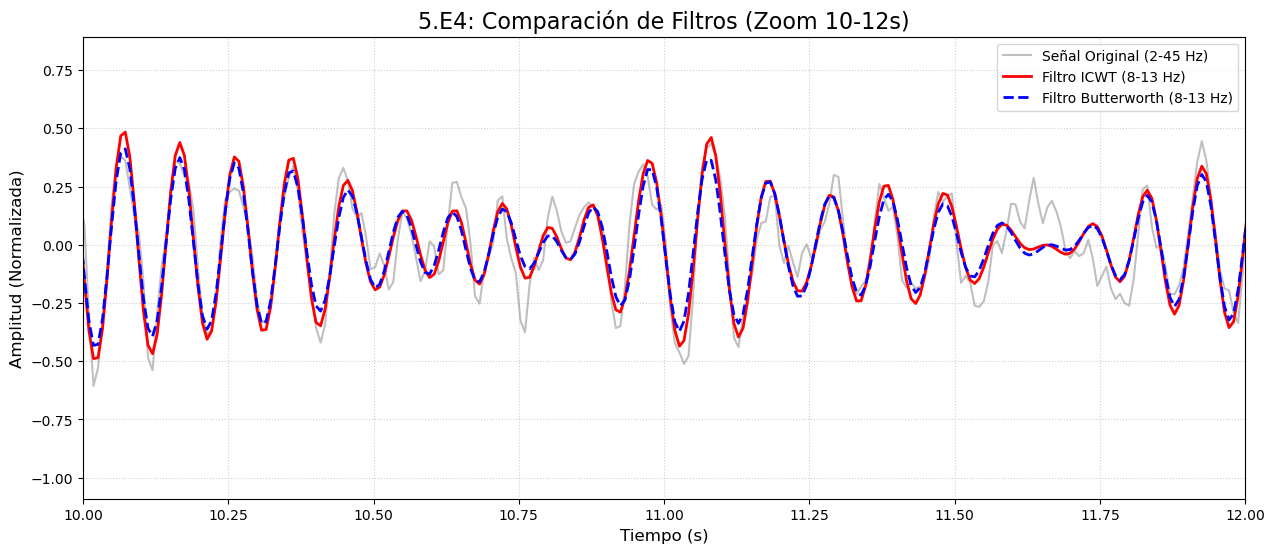

In [13]:
# --- Celda de Código: Ejercicio 5.E4 ---
from scipy.signal import butter, filtfilt

print("Ejercicio 5.E4: Comparación de Filtros (ICWT vs. Butterworth)")

# 1. Reutilizar 'y_alfa'

# 2. Diseñar Butterworth
nyq = 0.5 * fm
low = 8.0 / nyq
high = 13.0 / nyq
b, a = butter(4, [low, high], btype='band') # Orden 4 [cite: 38, 109]

# 3. Aplicar filtro Butterworth fase-cero
y_butter = filtfilt(b, a, senal) # [cite: 40, 116]

# 4. Graficar
plt.figure(figsize=(15, 6))
plt.plot(t_f, senal, color='gray', alpha=0.5, label='Señal Original (2-45 Hz)')
plt.plot(t_f, y_alfa, color='red', linewidth=2, 
         label='Filtro ICWT (8-13 Hz)')
plt.plot(t_f, y_butter, color='blue', linewidth=2, linestyle='--',
         label='Filtro Butterworth (8-13 Hz)')

# 5. Zoom
plt.title('5.E4: Comparación de Filtros (Zoom 10-12s)', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Amplitud (Normalizada)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim(10, 12) # Zoom
plt.show()

### 5.E5: Exploración de Wavelets Madre

[cite_start]**Objetivo:** Visualizar cómo la elección de la "wavelet madre" (Mother Wavelet) afecta la resolución del escalograma CWT, similar al Ejercicio 4.E2 de N4 sobre ventanas [cite: 572-574].

**Instrucciones:**
1.  Definir una lista de wavelets madre para probar:
    * `'morlet'`: `cwt.Morlet(6)` (nuestro estándar)
    * `'mexhat'`: `cwt.MexicanHat()` (Sombrero Mexicano)
    * `'paul'`: `cwt.Paul(4)` (Paul, orden 4)
2.  Crear una figura con 3 subplots (uno para cada wavelet).
3.  Hacer un bucle sobre la lista de wavelets. En cada iteración:
4.  Calcular la CWT (`cwt.cwt`) de `senal` usando la wavelet actual.
5.  Graficar el escalograma de potencia (`np.abs(coefs)**2`) en el subplot correspondiente.
6.  Observar las diferencias: ¿Cuál da mejor resolución en frecuencia? ¿Cuál da mejor resolución en tiempo?

## 5.9 Conclusión Final de la Serie (N1-N5) 

Esta serie de *notebooks* nos ha llevado en un viaje completo a través de los fundamentos del procesamiento de señales electrofisiológicas, comenzando con una señal de EEG cruda y ruidosa, y culminando en el análisis de dinámicas instantáneas de alta precisión.

El recorrido ha sido el siguiente:

* **N1 y N2 (Preparación):** Iniciamos cargando datos crudos y aprendiendo la importancia fundamental del pre-procesamiento: aplicar filtros (paso-banda, notch) para limpiar la señal de ruido muscular, de línea y de baja frecuencia, preparando el terreno para un análisis significativo.

* **N3 (Análisis Estático):** Con la señal limpia, aplicamos el análisis de Fourier (FFT) y la Densidad Espectral de Potencia (PSD). Estas herramientas clásicas nos respondieron a la pregunta: ***¿Qué*** *frecuencias están presentes?* Vimos picos claros en la banda alfa, pero este análisis promediaba la señal en el tiempo, ocultando *cuándo* ocurrían esos picos.

* **N4 (Análisis Dinámico Básico):** Dimos el salto al dominio tiempo-frecuencia con la **STFT**. El espectrograma nos permitió, por primera vez, responder a la pregunta: ***¿Cuándo*** *ocurren* *las frecuencias?*. Pudimos visualizar la **reactividad alfa** (la caída de potencia) como un evento en el tiempo. Sin embargo, nos enfrentamos a su limitación fundamental: el **compromiso de resolución fijo**, viéndonos forzados a elegir entre una buena resolución temporal (ventanas cortas) o una buena resolución frecuencial (ventanas largas).

* **N5 (Análisis Dinámico Adaptativo):** En este *notebook*, finalmente superamos la limitación de la STFT.
    * Introdujimos la **Transformada Wavelet Continua (CWT)**, un método de resolución multiescala que nos dio "lo mejor de ambos mundos": alta resolución temporal para eventos rápidos y alta resolución frecuencial para eventos lentos.
    * Utilizamos la **ICWT** como un filtro de fase cero de precisión quirúrgica para aislar una sola banda (alfa).
    * Aplicamos la **Transformada de Hilbert (HT)** a esa señal de banda estrecha, logrando el objetivo final: calcular la **Amplitud Instantánea $A(t)$**, una métrica que nos muestra la dinámica de la potencia, milisegundo a milisegundo, con una resolución que la STFT no puede alcanzar.

Hemos completado la jerarquía del análisis: desde la señal cruda, pasando por el filtrado, el análisis estático (PSD), el análisis dinámico-promediado (STFT) y, finalmente, el análisis dinámico-adaptativo (CWT) e instantáneo (HT). Ahora posees un conjunto de herramientas robusto para abordar una amplia gama de hipótesis neurocientíficas.

## 5.10 Bibliografía 

Addison, P. S. (2017). *The illustrated wavelet transform handbook: introductory theory and applications in science, engineering and technology*. CRC press.

Boashash, B. (Ed.). (2016). *Time-frequency signal analysis and processing: a comprehensive reference*. Academic press.

Cohen, M. X. (2014). *Analyzing neural time series data: theory and practice*. MIT press.

Flandrin, P. (1999). *Time-frequency/time-scale analysis*. Academic press.

Mallat, S. (2009). *A wavelet tour of signal processing: The sparse way*. Academic press.